In [74]:
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt 
import os 
import json

# Import Dataset

In [75]:
init_path = "../../data/"
train_data = pd.read_csv(init_path + "train_data.csv")
test_data = pd.read_csv(init_path + "test_data.csv")
val_data = pd.read_csv(init_path + "val_data.csv")

In [76]:
def extract_data(data):
    X = data["Source"]
    y = data["Label"]
    return np.asarray(X), np.asarray(y)

X_train, y_train = extract_data(train_data)
X_test, y_test = extract_data(test_data)
X_val, y_val = extract_data(val_data)

In [77]:
from collections import Counter 

print("Train labels ratio: ")
print(Counter(y_train.tolist()))

print("Test labels ratio: ")
print(Counter(y_test.tolist()))

print("Val labels ratio: ")
print(Counter(y_val.tolist()))

Train labels ratio: 
Counter({3: 12586, 2: 3298, 1: 152})
Test labels ratio: 
Counter({3: 2700, 2: 727, 1: 33})
Val labels ratio: 
Counter({3: 2725, 2: 702, 1: 32})


# Training and Testing 

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer() 
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

In [79]:
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

def get_metrics(ytrue, ypred, name, _type):
    print(classification_report(ytrue, ypred, zero_division=1))
    ret = classification_report(ytrue, ypred, output_dict=True, zero_division=1)
    ConfusionMatrixDisplay.from_predictions(ytrue, ypred)
    plt.savefig(os.path.join(results_dir, f"confusion_{_type}-{name}.png"), dpi=300)
    plt.show()
    print('\n\n')
    with open(os.path.join(results_dir, f"stats_{_type}-{name}.json"), "w") as f:
        json.dump(ret, f, indent=4)


For train set: 

              precision    recall  f1-score   support

           1       1.00      0.00      0.00       152
           2       0.86      0.07      0.13      3298
           3       0.80      1.00      0.89     12586

    accuracy                           0.80     16036
   macro avg       0.89      0.36      0.34     16036
weighted avg       0.81      0.80      0.72     16036



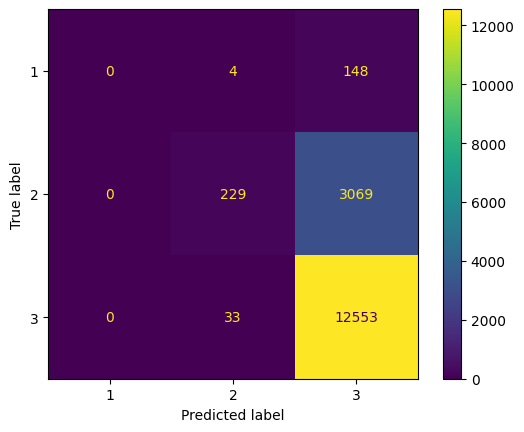





For validation set: 

              precision    recall  f1-score   support

           1       1.00      0.00      0.00        32
           2       0.33      0.03      0.05       702
           3       0.79      0.98      0.88      2725

    accuracy                           0.78      3459
   macro avg       0.71      0.34      0.31      3459
weighted avg       0.70      0.78      0.70      3459



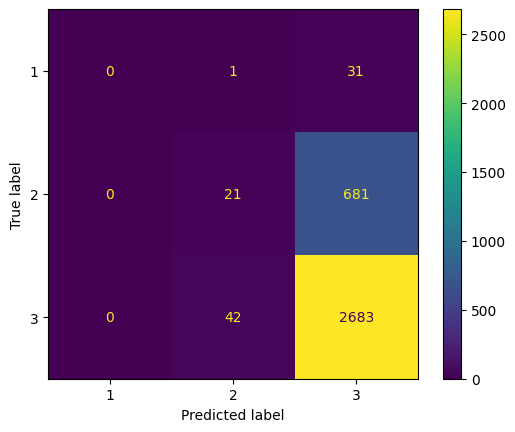





For test set: 

              precision    recall  f1-score   support

           1       1.00      0.00      0.00        33
           2       0.33      0.02      0.05       727
           3       0.78      0.99      0.87      2700

    accuracy                           0.77      3460
   macro avg       0.70      0.34      0.31      3460
weighted avg       0.69      0.77      0.69      3460



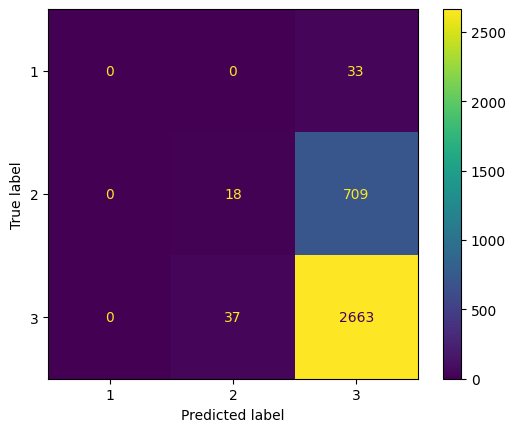

In [80]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

print("\nFor train set: \n")
y_pred = model.predict(X_train_vec)
get_metrics(y_train, y_pred, "normal", "train")

print("\nFor validation set: \n")
y_pred = model.predict(X_val_vec)
get_metrics(y_val, y_pred, "normal", "val")

print("\nFor test set: \n")
y_pred = model.predict(X_test_vec)
get_metrics(y_test, y_pred, "normal", "test")

### Now the problem in above approach is precision for class 1 is undefined => nothing got predicted as class 1 This is because of the imbalanced dataset i.e class 1 have very less samples compared to class 2, 3. So now we use a technique called "class weights" - which assigns higher weights to minority classes during model training to give them more importance . 

In [81]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights

array([35.16666667,  1.62078027,  0.4247047 ])


For train set: 

              precision    recall  f1-score   support

           1       0.29      1.00      0.45       152
           2       0.43      0.79      0.56      3298
           3       0.94      0.71      0.81     12586

    accuracy                           0.73     16036
   macro avg       0.55      0.83      0.60     16036
weighted avg       0.83      0.73      0.75     16036



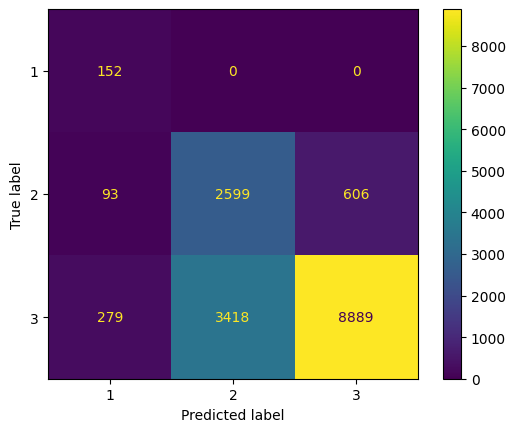





For validation set: 

              precision    recall  f1-score   support

           1       0.01      0.03      0.02        32
           2       0.22      0.39      0.28       702
           3       0.80      0.62      0.70      2725

    accuracy                           0.57      3459
   macro avg       0.34      0.35      0.33      3459
weighted avg       0.67      0.57      0.61      3459



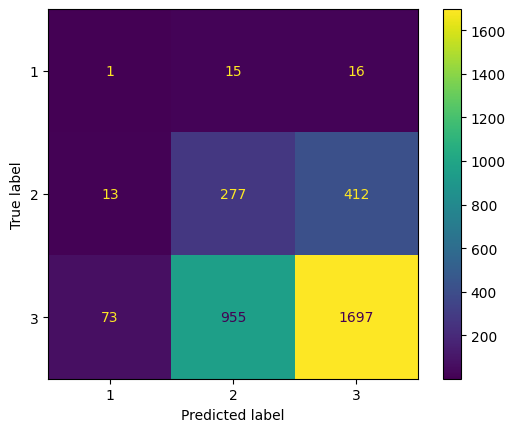





For test set: 

              precision    recall  f1-score   support

           1       0.03      0.06      0.04        33
           2       0.21      0.36      0.27       727
           3       0.78      0.63      0.70      2700

    accuracy                           0.57      3460
   macro avg       0.34      0.35      0.33      3460
weighted avg       0.66      0.57      0.60      3460



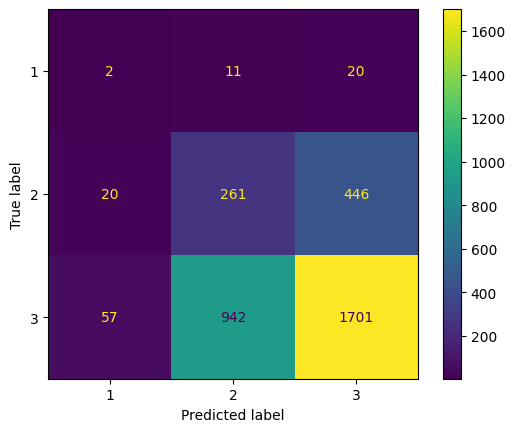

In [82]:
#Train logistic regression model with class weights
model = LogisticRegression(max_iter=1000, class_weight=dict(zip(np.unique(y_train), class_weights)))
model.fit(X_train_vec, y_train)

print("\nFor train set: \n")
y_pred = model.predict(X_train_vec)
get_metrics(y_train, y_pred, "class_weights_balanced", "train")

print("\nFor validation set: \n")
y_pred = model.predict(X_val_vec)
get_metrics(y_val, y_pred, "class_weights_balanced", "val")

print("\nFor test set: \n")
y_pred = model.predict(X_test_vec)
get_metrics(y_test, y_pred, "class_weights_balanced", "test")

### Still the results for class 1 is very less even using 'balanced' class weight. So now i will try to assign a bit higer values compared to the 'balanced' one and check 

In [87]:
class_weights = [40.00, 3.00, 0.50]


For train set: 

              precision    recall  f1-score   support

           1       0.30      1.00      0.46       152
           2       0.37      0.95      0.53      3298
           3       0.99      0.55      0.71     12586

    accuracy                           0.64     16036
   macro avg       0.55      0.83      0.57     16036
weighted avg       0.86      0.64      0.67     16036



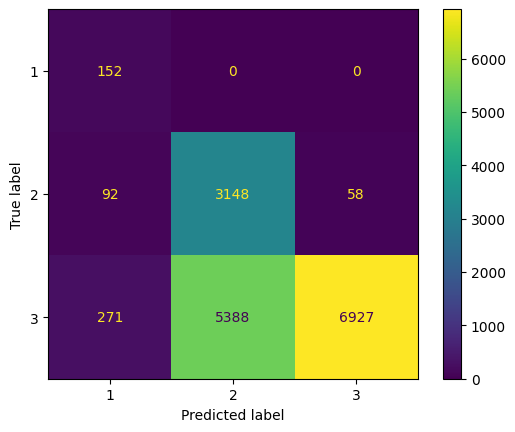





For validation set: 

              precision    recall  f1-score   support

           1       0.01      0.03      0.02        32
           2       0.22      0.54      0.31       702
           3       0.80      0.48      0.61      2725

    accuracy                           0.49      3459
   macro avg       0.35      0.35      0.31      3459
weighted avg       0.68      0.49      0.54      3459



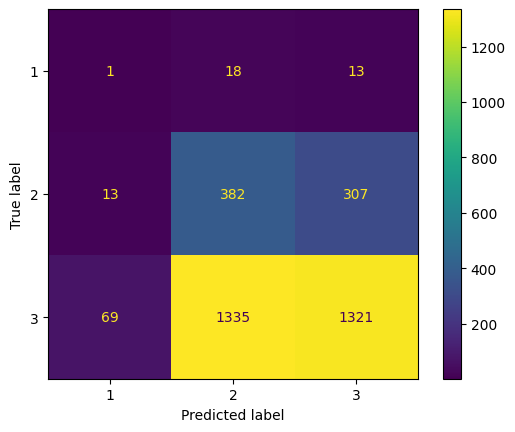





For test set: 

              precision    recall  f1-score   support

           1       0.03      0.06      0.04        33
           2       0.22      0.50      0.30       727
           3       0.79      0.49      0.61      2700

    accuracy                           0.49      3460
   macro avg       0.34      0.35      0.32      3460
weighted avg       0.66      0.49      0.54      3460



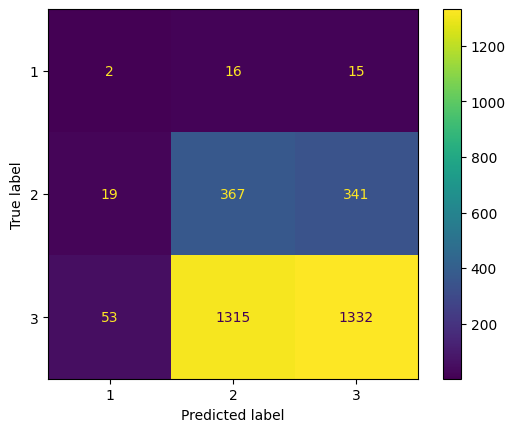

In [88]:
model = LogisticRegression(max_iter=1000, class_weight=dict(zip(np.unique(y_train), class_weights)))
model.fit(X_train_vec, y_train)

print("\nFor train set: \n")
y_pred = model.predict(X_train_vec)
get_metrics(y_train, y_pred, "class_weights", "train")

print("\nFor validation set: \n")
y_pred = model.predict(X_val_vec)
get_metrics(y_val, y_pred, "class_weights", "val")

print("\nFor test set: \n")
y_pred = model.predict(X_test_vec)
get_metrics(y_test, y_pred, "class_weights", "test")

### Now the results for class 3 became worser whereas for class 1, 2 the results didn't change much. 
### Now we will try to use SMOTE technique and check the results . 

In [85]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)


For train set: 

              precision    recall  f1-score   support

           1       0.29      1.00      0.45       152
           2       0.45      0.72      0.55      3298
           3       0.92      0.75      0.83     12586

    accuracy                           0.75     16036
   macro avg       0.55      0.82      0.61     16036
weighted avg       0.82      0.75      0.77     16036



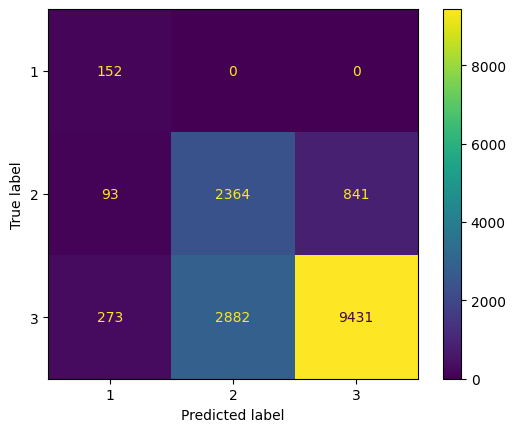





For validation set: 

              precision    recall  f1-score   support

           1       0.01      0.03      0.02        32
           2       0.22      0.34      0.27       702
           3       0.79      0.66      0.72      2725

    accuracy                           0.59      3459
   macro avg       0.34      0.35      0.34      3459
weighted avg       0.67      0.59      0.62      3459



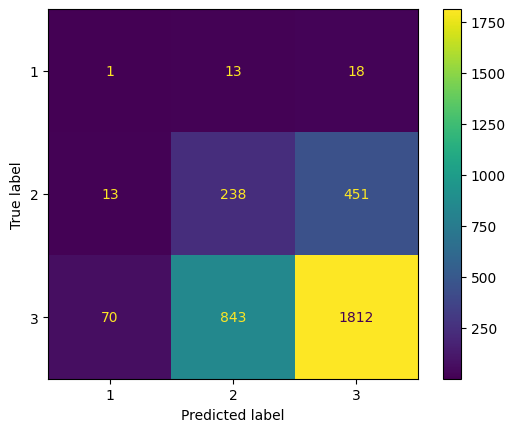





For test set: 

              precision    recall  f1-score   support

           1       0.03      0.06      0.04        33
           2       0.23      0.33      0.27       727
           3       0.79      0.68      0.73      2700

    accuracy                           0.60      3460
   macro avg       0.35      0.36      0.35      3460
weighted avg       0.66      0.60      0.63      3460



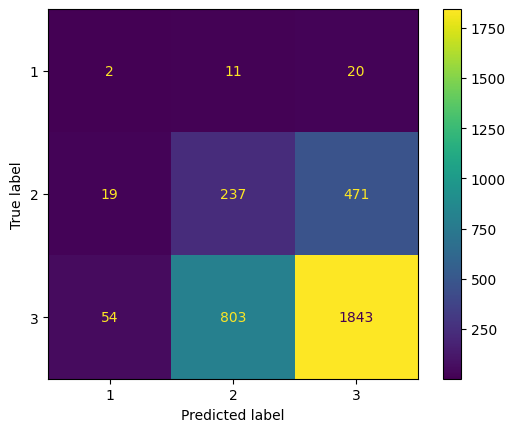

In [86]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)

print("\nFor train set: \n")
y_pred = model.predict(X_train_vec)
get_metrics(y_train, y_pred, "smote", "train")

print("\nFor validation set: \n")
y_pred = model.predict(X_val_vec)
get_metrics(y_val, y_pred, "smote", "val")

print("\nFor test set: \n")
y_pred = model.predict(X_test_vec)
get_metrics(y_test, y_pred, "smote", "test")

### The results for handling imbalanced dataset using tecnhiques like SMOTE and class_weights gave almost same results . And i conclude that logistic regression is not a good technique for fluency classification as the results turned out to be not satisfying.